## Входные данные
Датасет: **datasets/students_simple.csv**
Выбираются 2 слобкика данных по формулам:
1) $N \% 5$
2) $N^2 \% 5 + 5$
где $N$ - номер в списке


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.float_format', lambda x: f"{x:.4f}")

DATA_PATH = '/Users/victoriasamsonova/bsu/oiad/oiad-11-2025/datasets/students_simple.csv'
N = 24

df = pd.read_csv(DATA_PATH)
idx1 = N % 5
idx2 = (N * N) % 5 + 5

column_name_1 = df.columns[idx1]
column_name_2 = df.columns[idx2]

pair_df = df[[column_name_1, column_name_2]].dropna()
series_1 = pair_df[column_name_1].astype(float).to_numpy()
series_2 = pair_df[column_name_2].astype(float).to_numpy()

n = len(series_1)
print(f"Выбраны столбцы: {column_name_1} и {column_name_2}. Число пар после очистки: n={n}")

Выбраны столбцы: pages и bmi. Число пар после очистки: n=20



## 1. Расчет корреляций
1. Фехнера
2. Пирсона + доверительный интервал
3. Спирмена
4. Кенделла

In [13]:
# Корреляция Фехнера
def fechner_correlation(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    mx = np.mean(x)
    my = np.mean(y)
    sx = np.sign(x - mx)
    sy = np.sign(y - my)
    # Игнорируем нулевые отклонения (где sign == 0)
    mask = (sx != 0) & (sy != 0)
    if not np.any(mask):
        return np.nan
    sx = sx[mask]
    sy = sy[mask]
    same = np.sum(sx == sy)
    diff = np.sum(sx != sy)
    return (same - diff) / (same + diff)

# Корреляция Пирсона
# Реализация идентична numpy.corrcoef, но явно
def pearson_correlation(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    xm = x - x.mean()
    ym = y - y.mean()
    denom = np.sqrt((xm ** 2).sum() * (ym ** 2).sum())
    if denom == 0:
        return np.nan
    return (xm * ym).sum() / denom

# Корреляция Спирмена — корректные ранги с учетом связей
from scipy.stats import rankdata

def spearman_correlation(x, y):
    rx = rankdata(x, method='average')
    ry = rankdata(y, method='average')
    return pearson_correlation(rx, ry)

# Корреляция Кендалла tau-b (корректна при связях)
def kendall_correlation(x, y):
    tau, _ = stats.kendalltau(x, y, variant='b')
    return tau

# Доверительный интервал Пирсона через преобразование Фишера z
# и p-value через t-статистику

def pearson_ci_p(x, y, alpha=0.05):
    r = pearson_correlation(x, y)
    n = len(x)
    if n < 4 or np.isnan(r):
        return r, (np.nan, np.nan), np.nan
    # Fisher z
    z = 0.5 * np.log((1 + r) / (1 - r))
    se_z = 1 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    z_lo = z - z_crit * se_z
    z_hi = z + z_crit * se_z
    # Обратное преобразование
    lo = (np.exp(2 * z_lo) - 1) / (np.exp(2 * z_lo) + 1)
    hi = (np.exp(2 * z_hi) - 1) / (np.exp(2 * z_hi) + 1)
    # t-статистика для проверки H0: r=0
    t_stat = r * np.sqrt((n - 2) / (1 - r ** 2))
    p_value = 2 * stats.t.sf(np.abs(t_stat), df=n - 2)
    return r, (lo, hi), p_value

# Расчет корреляций
fechner_corr = fechner_correlation(series_1, series_2)
pearson_corr, (ci_lower, ci_upper), pearson_pval = pearson_ci_p(series_1, series_2)
spearman_corr = spearman_correlation(series_1, series_2)
kendall_corr = kendall_correlation(series_1, series_2)

# Сравнение с библиотечными реализациями
pearson_lib = stats.pearsonr(series_1, series_2)
spearman_lib = stats.spearmanr(series_1, series_2)
kendall_lib = stats.kendalltau(series_1, series_2, variant='b')

print(f"Корреляция Фехнера: {fechner_corr:.4f}")
print(f"Корреляция Пирсона (функция): {pearson_corr:.4f}, p-value: {pearson_pval:.4f}, CI95%: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Корреляция Пирсона (scipy): {pearson_lib.statistic:.4f}, p-value: {pearson_lib.pvalue:.4f}")
print(f"Корреляция Спирмена (функция): {spearman_corr:.4f}")
print(f"Корреляция Спирмена (scipy): {spearman_lib.statistic:.4f}")
print(f"Корреляция Кендалла (функция): {kendall_corr:.4f}")
print(f"Корреляция Кендалла (scipy): {kendall_lib.statistic:.4f}")

Корреляция Фехнера: -0.4000
Корреляция Пирсона (функция): -0.1795, p-value: 0.4489, CI95%: [-0.5762, 0.2857]
Корреляция Пирсона (scipy): -0.1795, p-value: 0.4489
Корреляция Спирмена (функция): -0.3239
Корреляция Спирмена (scipy): -0.3239
Корреляция Кендалла (функция): -0.2442
Корреляция Кендалла (scipy): -0.2442


Доверительный интервал Пирсона включает 0, поэтому статистически значимой линейной связи при α=0.05 нет.


## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)

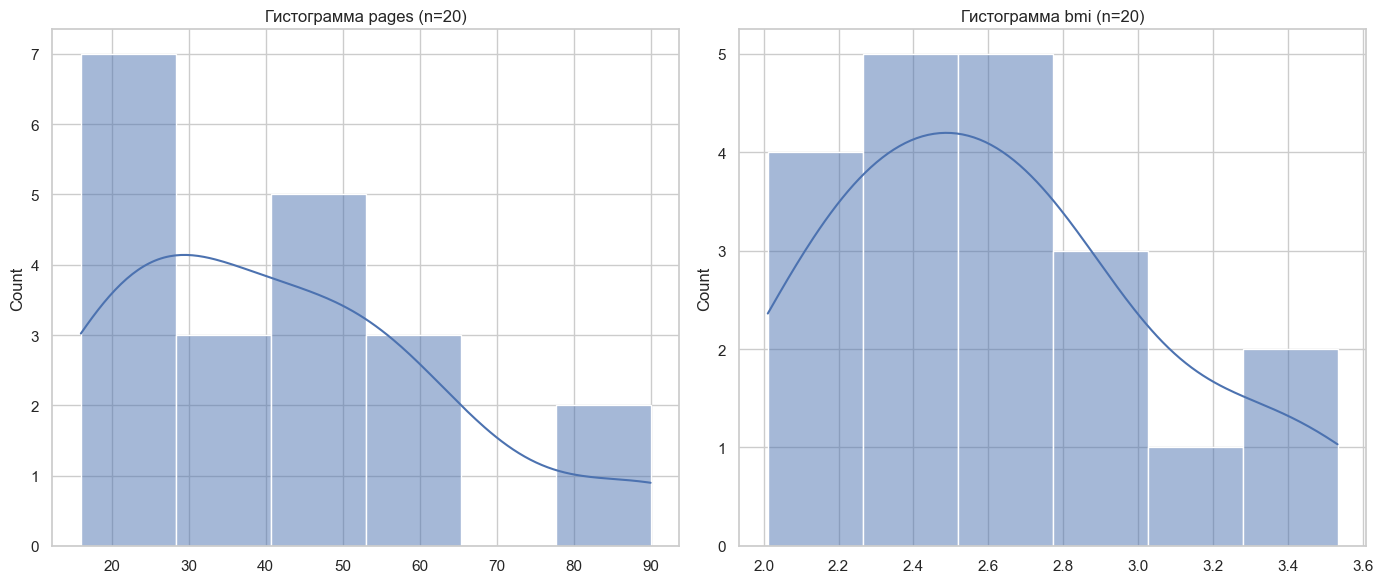

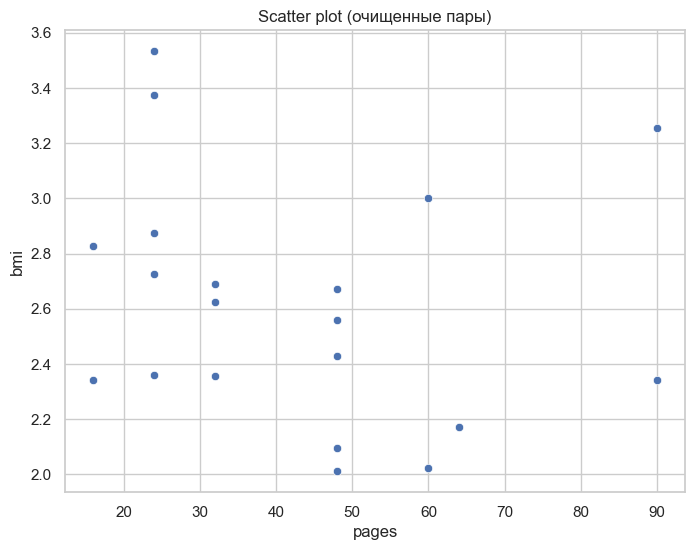

In [14]:
sns.set(style='whitegrid')
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.histplot(series_1, kde=True)
plt.title(f'Гистограмма {column_name_1} (n={len(series_1)})')

plt.subplot(1,2,2)
sns.histplot(series_2, kde=True)
plt.title(f'Гистограмма {column_name_2} (n={len(series_2)})')
plt.tight_layout()
plt.show()

# Scatter plot на очищенных и выравненных данных
plt.figure(figsize=(8,6))
sns.scatterplot(x=series_1, y=series_2)
plt.xlabel(column_name_1)
plt.ylabel(column_name_2)
plt.title('Scatter plot (очищенные пары)')
plt.show()

## 3. Уравнение регрессии
Построить уравнение регрессии по видам:
1. линейная, $y=w_1 x + w_0$
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$ 
4. показательная, $y = w_1^x \cdot w_0$

Линейная: y = w1*x + w0
  w0=2.7650, w1=-0.0036, R^2=0.0322, F=0.5993, p=0.4489
Квадратичная: y = w2*x^2 + w1*x + w0
  w0=3.4518, w1=-0.0371, w2=0.0003, R^2=0.1830, F=1.9036, p=0.1795
Гиперболическая: y = w1/x + w0 (x != 0)
  w0=2.3922, w1=7.3407, R^2=0.0670, F=1.2924, p=0.2705
Показательная: y = a*b^x (y>0)
  a=2.7439, b=0.9986, R^2=0.0289, F=0.5358, p=0.4736


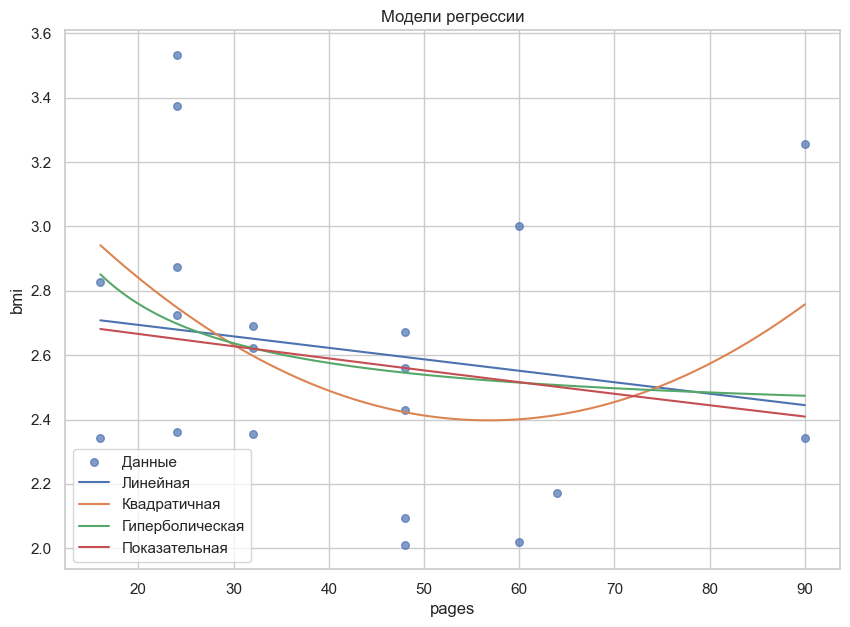

In [15]:
import warnings
warnings.filterwarnings('ignore')

# Вспомогательные функции для регрессии

def design_matrix_linear(x):
    X = np.c_[np.ones_like(x), x]
    return X

def design_matrix_quadratic(x):
    X = np.c_[np.ones_like(x), x, x**2]
    return X

def design_matrix_hyperbolic(x):
    # y = w1 * (1/x) + w0, область определения: x != 0
    mask = x != 0
    return np.c_[np.ones_like(x[mask]), 1.0 / x[mask]], mask

def fit_ols(X, y):
    # Решение через псевдообратную (устойчиво)
    w = np.linalg.pinv(X) @ y
    y_hat = X @ w
    residuals = y - y_hat
    n, k = X.shape
    sse = float(np.sum(residuals**2))
    sst = float(np.sum((y - y.mean())**2))
    r2 = 1.0 - sse / sst if sst > 0 else np.nan
    # F-тест значимости регрессии
    if k > 1 and n > k and r2 < 1:
        F = (r2 / (1 - r2)) * ((n - k) / (k - 1))
        p = stats.f.sf(F, dfn=k - 1, dfd=n - k)
    else:
        F, p = np.nan, np.nan
    return w, y_hat, r2, F, p

# 1) Линейная: y = w1 x + w0
X_lin = design_matrix_linear(series_1)
w_lin, yhat_lin, r2_lin, F_lin, p_lin = fit_ols(X_lin, series_2)

# 2) Квадратичная: y = w2 x^2 + w1 x + w0
X_quad = design_matrix_quadratic(series_1)
w_quad, yhat_quad, r2_quad, F_quad, p_quad = fit_ols(X_quad, series_2)

# 3) Гиперболическая: y = w1 / x + w0
X_hyp, mask_hyp = design_matrix_hyperbolic(series_1)
w_hyp, yhat_hyp, r2_hyp, F_hyp, p_hyp = fit_ols(X_hyp, series_2[mask_hyp])

# 4) Показательная: y = a * b^x => ln y = ln a + x ln b
# Используем только y > 0
mask_exp = series_2 > 0
x_exp = series_1[mask_exp]
y_exp = series_2[mask_exp]
if len(y_exp) >= 2:
    X_exp = design_matrix_linear(x_exp)
    w_exp, yhat_exp_log, r2_exp_log, F_exp_log, p_exp_log = fit_ols(X_exp, np.log(y_exp))
    # Преобразуем параметры обратно: ln a = w0, ln b = w1
    a_hat = np.exp(w_exp[0])
    b_hat = np.exp(w_exp[1])
    # Прогнозы в исходной шкале
    yhat_exp = a_hat * (b_hat ** x_exp)
    # R^2 в исходной шкале оцениваем напрямую
    sse_exp = float(np.sum((y_exp - yhat_exp)**2))
    sst_exp = float(np.sum((y_exp - y_exp.mean())**2))
    r2_exp = 1.0 - sse_exp / sst_exp if sst_exp > 0 else np.nan
    # F для исходной шкалы пересчитаем по r2_exp
    n_exp = len(y_exp)
    k_exp = 2
    if r2_exp < 1 and n_exp > k_exp:
        F_exp = (r2_exp / (1 - r2_exp)) * ((n_exp - k_exp) / (k_exp - 1))
        p_exp = stats.f.sf(F_exp, dfn=k_exp - 1, dfd=n_exp - k_exp)
    else:
        F_exp, p_exp = np.nan, np.nan
else:
    w_exp = np.array([np.nan, np.nan])
    a_hat = np.nan
    b_hat = np.nan
    yhat_exp = np.full_like(series_1, fill_value=np.nan, dtype=float)
    r2_exp = np.nan
    F_exp, p_exp = np.nan, np.nan

print("Линейная: y = w1*x + w0")
print(f"  w0={w_lin[0]:.4f}, w1={w_lin[1]:.4f}, R^2={r2_lin:.4f}, F={F_lin:.4f}, p={p_lin:.4f}")
print("Квадратичная: y = w2*x^2 + w1*x + w0")
print(f"  w0={w_quad[0]:.4f}, w1={w_quad[1]:.4f}, w2={w_quad[2]:.4f}, R^2={r2_quad:.4f}, F={F_quad:.4f}, p={p_quad:.4f}")
print("Гиперболическая: y = w1/x + w0 (x != 0)")
print(f"  w0={w_hyp[0]:.4f}, w1={w_hyp[1]:.4f}, R^2={r2_hyp:.4f}, F={F_hyp:.4f}, p={p_hyp:.4f}")
print("Показательная: y = a*b^x (y>0)")
print(f"  a={a_hat:.4f}, b={b_hat:.4f}, R^2={r2_exp:.4f}, F={F_exp:.4f}, p={p_exp:.4f}")

# Визуализация моделей
x_grid = np.linspace(np.min(series_1), np.max(series_1), 200)
Xg_lin = design_matrix_linear(x_grid)
yg_lin = Xg_lin @ w_lin
Xg_quad = design_matrix_quadratic(x_grid)
yg_quad = Xg_quad @ w_quad
mask_g_hyp = x_grid != 0
Xg_hyp = np.c_[np.ones_like(x_grid[mask_g_hyp]), 1.0 / x_grid[mask_g_hyp]]
yg_hyp = Xg_hyp @ w_hyp

yg_exp = np.full_like(x_grid, np.nan, dtype=float)
if not np.isnan(b_hat):
    yg_exp = a_hat * (b_hat ** x_grid)

plt.figure(figsize=(10,7))
plt.scatter(series_1, series_2, s=30, alpha=0.7, label='Данные')
plt.plot(x_grid, yg_lin, label='Линейная')
plt.plot(x_grid, yg_quad, label='Квадратичная')
plt.plot(x_grid[mask_g_hyp], yg_hyp, label='Гиперболическая')
if not np.all(np.isnan(yg_exp)):
    plt.plot(x_grid, yg_exp, label='Показательная')
plt.xlabel(column_name_1)
plt.ylabel(column_name_2)
plt.title('Модели регрессии')
plt.legend()
plt.show()


## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соответствие модели данным с помощью критерия Фишера

In [16]:
# Выбор лучшей и худшей модели по R^2, проверка критерием Фишера
models_info = [
    ("Линейная", r2_lin, F_lin, p_lin),
    ("Квадратичная", r2_quad, F_quad, p_quad),
    ("Гиперболическая", r2_hyp, F_hyp, p_hyp),
]
if not np.isnan(r2_exp):
    models_info.append(("Показательная", r2_exp, F_exp, p_exp))

# Фильтруем модели, у которых R^2 определен
models_info = [m for m in models_info if not np.isnan(m[1])]

best = max(models_info, key=lambda t: t[1]) if models_info else None
worst = min(models_info, key=lambda t: t[1]) if models_info else None

print("Модели по убыванию R^2:")
for name, r2, Fv, pv in sorted(models_info, key=lambda t: t[1], reverse=True):
    print(f"  {name:14s} R^2={r2:.4f}  F={Fv:.4f}  p={pv:.4f}")

alpha = 0.05
if best:
    print(f"\nЛучшая модель: {best[0]}  R^2={best[1]:.4f}")
    print(f"  Проверка значимости (Фишер): F={best[2]:.4f}, p={best[3]:.4f}")
    print(f"  Вывод: {'значима' if best[3] < alpha else 'не значима'} при alpha={alpha}")

if worst:
    print(f"\nХудшая модель: {worst[0]}  R^2={worst[1]:.4f}")
    print(f"  Проверка значимости (Фишер): F={worst[2]:.4f}, p={worst[3]:.4f}")
    print(f"  Вывод: {'значима' if worst[3] < alpha else 'не значима'} при alpha={alpha}")


Модели по убыванию R^2:
  Квадратичная   R^2=0.1830  F=1.9036  p=0.1795
  Гиперболическая R^2=0.0670  F=1.2924  p=0.2705
  Линейная       R^2=0.0322  F=0.5993  p=0.4489
  Показательная  R^2=0.0289  F=0.5358  p=0.4736

Лучшая модель: Квадратичная  R^2=0.1830
  Проверка значимости (Фишер): F=1.9036, p=0.1795
  Вывод: не значима при alpha=0.05

Худшая модель: Показательная  R^2=0.0289
  Проверка значимости (Фишер): F=0.5358, p=0.4736
  Вывод: не значима при alpha=0.05
